# Practice Session 03: Find near-duplicates using shingling

<font size="+2" color="blue">Additional results: various ngram sizes</font>

Author: <font color="blue">Guillem Escriba Molto</font>

E-mail: <font color="blue">guillem.escriba01@estudiant.upf.edu</font>

Date: <font color="blue">20/10/2022</font>

In [1]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import datetime

In [2]:
# Input file
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []
MAX_MESSAGES = 10000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 10000 documents


# 1. Auxiliary functions

In [3]:
def jaccard_similarity(set1, set2):
    if(len(set1)==0 or len(set2) == 0): # Checks if there is an empty set to avoid division by 0
        return 0
    set1 = set(set1) # Transform lists to sets
    set2 = set(set2)
    jaccard_coeff = len(set1.intersection(set2))/len(set1.union(set2)) # Compute Jaccard Coefficient
    return jaccard_coeff


In [4]:
set1 = {1,2,3}
set2 = {1,2}
print(jaccard_similarity(set1,set2))
set1 = {1,2,4,7}
set2 = {1,2,4,5,7,8}
print(jaccard_similarity(set1,set2))
set1 = {1,2,3}
set2 = {1,2,3,4}
print(jaccard_similarity(set1,set2))
set1 = {1,2,3,4,5,6}
set2 = {1,2,3,4,5,6,8,9}
print(jaccard_similarity(set1,set2))
set1 = {1,2,3}
set2 = {1,2,3}
print(jaccard_similarity(set1,set2))
set1 = {1,2,3,4,5,6}
set2 = {1,2,3,4,5,6}
print(jaccard_similarity(set1,set2))
set1 = {1,2,3}
set2 = {4,5,6,7}
print(jaccard_similarity(set1,set2))
set1 = {1}
set2 = {0}
print(jaccard_similarity(set1,set2))



0.6666666666666666
0.6666666666666666
0.75
0.75
1.0
1.0
0.0
0.0


In [5]:
def clean(message):
    
    message = message.replace('RT','',1) # Deletes the first RT
    
    message = message.lower() # Converts to lowercase
    
    # Romanizes the text
    message = message.replace('à','a')
    message = message.replace('á','a')
    message = message.replace('è','e')
    message = message.replace('é','e')
    message = message.replace('í','i')
    message = message.replace('ò','ò')
    message = message.replace('ó','ó')
    message = message.replace('ú','u')
    message = message.replace('ç','c')
    message = message.replace('l·l','ll')
    message = message.replace('ñ','n')
    
    # Removes the URLs
    message = re.sub('http://\S+|https://\S+', '', message)
    
    # Removes the spaces at the start and the end of the message
    message = message.strip()
    
    # Removes anything that is neither a letter nor a number
    message = re.sub(r"[^A-Za-z0-9 ]","", message)
    
    # Replaces double spaces by single spaces
    message = message.replace('  ',' ')
    
    return message

In [6]:
test =  "  RT   @àáéèíòóúçl·lñhttphttps#|@~#@ Ayer cené  macarrones. https://docs.python.org/3/library/re.html#re.sub .  "
print(clean(test))

aaeeiucllnhttphttps ayer cene macarrones 


# 2. Implement an n-gram extractor

In [7]:
def ngrams(text, size):
    MIN_TOKEN_LENGTH = 2 # Defines the minimum size of a word to become a ngram
    temp = clean(text).split() # Splits the message in a list of words in a temporal list
    tokens = [] 
    ngrams = []
    # Skip the tokens whose length is smaller than MIN_TOKEN_LENGTH
    for i in range(len(temp)):
        if(len(temp[i])>=MIN_TOKEN_LENGTH):
            tokens.append(temp[i])
    # Create the ngrams list
    for i in range(len(tokens)-size+1): # Iterates through all the tokens
        temp = [tokens[j] for j in range(i,i+size)] # Combines tokens to make n-grams
        ngrams.append(" ".join(temp)) # Adds a space between tokens
        
    return ngrams

In [8]:
print(messages[9780])
print(ngrams(messages[9780], 2))

RT @diariARA: Comerciants xinesos donen mascaretes i gel antisèptic a Badalona per lluitar contra el coronavirus https://t.co/ybYXFxphIu
['diariara comerciants', 'comerciants xinesos', 'xinesos donen', 'donen mascaretes', 'mascaretes gel', 'gel antiseptic', 'antiseptic badalona', 'badalona per', 'per lluitar', 'lluitar contra', 'contra el', 'el coronavirus']


# 3. Estimation for brute force method

In [9]:
# LEAVE AS-IS

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

In [10]:
x = []
y = []
ngram_size = 3
for limit in range(1,2001,150):
    y.append(time_brute_force_similarities(messages, limit, ngram_size))
    x.append(limit)



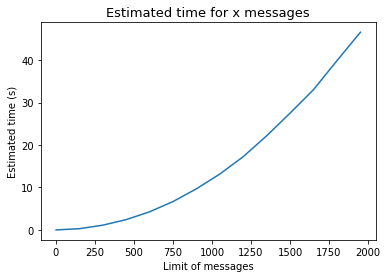

In [11]:
plt.plot(x,y)
plt.xlabel(xlabel='Limit of messages')
plt.ylabel(ylabel='Estimated time (s)')
plt.title("Estimated time for x messages", fontsize = 13.0)
plt.show()

In [12]:
limit = 10000
ngram_size = 3
time_brute_force_similarities(messages, limit, ngram_size)

1206.5665391999999

In [13]:
n = len(x)
n_messages = x[n-1]
time_spent = y[n-1]
max_messages = 10000
# Since we are creating a matrix with shape n_messages x n_messages we are working with n^2
estimated_time = int((max_messages**2/n_messages**2)*time_spent)
# Time calculations
temp = estimated_time
hours = int(temp/3600)
temp -= hours*3600
minutes = int(temp/60)
seconds = int(temp - minutes*60)
print("The time required would be {}h {}min and {}s ({}s) to compute the entire matrix of {} messages.".format(hours,minutes,seconds,estimated_time,max_messages))

The time required would be 0h 20min and 23s (1223s) to compute the entire matrix of 10000 messages.


<font size="+1">With only this graph we cannot be sure of how much time it will take to compute the full matrix. As we can see in the plot, it follows some kind of quadratic function. If we look at the function "time_brute_force_similarities" it seems to have a complexity of O(n^2) which reinforce our previous hypothesis that the plot follows some kinde of quadratic function. In the cells of above we can see the time spent by brute force, 1230'542 seconds and our approximation, 1251 seconds or 20 minutes and 51 seconds which is very close to the exact result so we can conclude it follows a quadratic function that would be approximately  Constant*Number_of_Messages^2. </font>

# 4. Computing the doc-ngram matrix

## 4.1 Create list of all ngrams

In [14]:
NGRAM_SIZE = 3

ngram_to_index = {}
index_to_ngram = {}
next_index = 0

for message in messages: # Iterates through all messages
    all_ngrams = ngrams(message, NGRAM_SIZE) # Creates all the ngrams of that document(message)
    for ngram in all_ngrams: # Iterates through all ngrams
        if(ngram not in ngram_to_index): # If it is not included in the dictionary 
            ngram_to_index[ngram] = next_index # We add the ngram to the dict
            index_to_ngram[next_index] = ngram # Inverse dict
            next_index += 1 # Count the number of ngrams
        
num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))

There are 67090 distinct ngrams in the 10000 documents


In [15]:
ind1 = ngram_to_index["tancat escoles fins"]
ind2 = ngram_to_index["garantir la seguretat"]
print(ind1)
print(ind2)
print(index_to_ngram[ind1])
print(index_to_ngram[ind2])


940
34
tancat escoles fins
garantir la seguretat


## 2.2 Create table ngrams x documents

In [16]:
# LEAVE AS-IS

# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 67090 rows (distinct shingles) x 10000 columns (distinct documents)


In [17]:
ngram_size = 3
for docid in range(len(messages)): # Iterate through all docs
    message = messages[docid] 
    all_ngrams = ngrams(message, ngram_size)
    for ngram in all_ngrams: # Iterates through all ngrams
        if(ngram in ngram_to_index): # If the engram is in the dict
            ngram_id = ngram_to_index[ngram] # We find the ngram id
            M_ngram_doc[ngram_id][docid] = True # If the shingle is in the message M_ngram_doc = true
        else:
            M_ngram_doc[ngram_id][docid] = False
            


In [18]:
print("Density of matrix: {}%".format(round(sum(sum(M_ngram_doc))/(M_ngram_doc.shape[0]*M_ngram_doc.shape[1]),5)))

Density of matrix: 0.00023%


In [19]:
print(sum(M_ngram_doc[9602]))
print(sum(M_ngram_doc[941]))

3
2


# 3. Implement a permutation generator

In [20]:
def random_permutation(k):
    x = list(range(0,k)) # Creates an array of 0,1,...,k-1 
    random.shuffle(x) # It disorder the numbers
    return x
print(random_permutation(98))
    
    

[30, 10, 1, 20, 7, 72, 62, 31, 9, 65, 42, 78, 19, 38, 58, 66, 4, 46, 60, 77, 64, 6, 59, 81, 32, 52, 69, 41, 61, 12, 87, 51, 75, 29, 47, 50, 28, 2, 48, 21, 89, 40, 68, 43, 11, 26, 54, 34, 97, 35, 15, 17, 55, 3, 90, 76, 16, 95, 45, 84, 94, 37, 80, 67, 36, 8, 96, 56, 24, 74, 13, 71, 63, 85, 91, 23, 0, 92, 14, 73, 70, 27, 88, 57, 39, 49, 82, 25, 18, 44, 33, 53, 22, 93, 83, 79, 86, 5]


In [21]:
# LEAVE AS-IS

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (ek)", "2 (do)", "3 (tīn)", "4 (chār)", "5 (pāṅc)"]
original_list_2 = ["1 (jedan)", "2 (dva)", "3 (tri)", "4 (četiri)", "5 (pet)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['1 (ek)', '3 (tīn)', '4 (chār)', '2 (do)', '5 (pāṅc)']
['1 (jedan)', '3 (tri)', '4 (četiri)', '2 (dva)', '5 (pet)']

Test another permutation
['4 (chār)', '2 (do)', '5 (pāṅc)', '3 (tīn)', '1 (ek)']
['4 (četiri)', '2 (dva)', '5 (pet)', '3 (tri)', '1 (jedan)']


# 4. Compute the signature of each document

In [34]:
# Leave this code as-is

NUM_PERMUTATIONS = 5

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))
    
# Visualize the permutations by printing their first 3 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, ..." % (i, permutation[0], permutation[1], permutation[2] ))

Permutation 0: 37297, 21409, 49413, ...
Permutation 1: 60243, 47863, 11370, ...
Permutation 2: 22658, 2383, 61232, ...
Permutation 3: 30839, 35740, 31448, ...
Permutation 4: 54372, 38390, 21605, ...


In [35]:
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True: # If the shingle is in the message (M_ngram_doc == true) we return the shingle id
            return shingle_id
    return -1

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        M_signature_doc[permutation_num,docid] = int(find_first_one(docid,permutation)) # Adds a succesion of shingles to make a signature of size NUM_PERMUTATIONS
        

Creating signatures for permutation 1/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 2/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 3/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Sca

In [37]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, i] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))

        
i = 385
j = 627

print_sig(messages, M_ngram_doc, M_signature_doc, i )

print()

print_sig(messages, M_ngram_doc, M_signature_doc, j )

Document #385
Message       : RT @gencat: 🔴 El @govern de la @gencat anuncia el #confinament de tot Catalunya.

Davant l’emergència de la #COVID19, el missatge és clau:…
Clean message : gencat el govern de la gencat anuncia el confinament de tot catalunyadavant lemergencia de la covid19 el missatge es clau
Ngrams        : [62, 3337, 3463, 4108, 4914, 4915, 4916, 4917, 4918, 4919, 4920, 4921, 4922, 4923, 4924, 4925, 4926, 4927]
Signature     : [4922.0, 4108.0, 4918.0, 4917.0, 4921.0]

Document #627
Message       : PROCICAT_CORONAVIRUS. El @govern de la @gencat anuncia el #confinament de tot Catalunya. Davant l’emergència de la #COVID19, el missatge és clau: limitar la mobilitat ajudarà a evitar la propagació del #coronavirus. Evitem desplaçaments i reduïm la vida social #JoEmQuedoACasa
Clean message : procicatcoronavirus el govern de la gencat anuncia el confinament de tot catalunya davant lemergencia de la covid19 el missatge es clau limitar la mobilitat ajudara a evitar la propagaci d

# 5. Compare all pairs of signatures

In [38]:
def compare_signatures(messages):    
    is_possible_duplicate = {}
    nduplicates = 0
    # Iterate through all documents
    for docid1 in range(len(messages)):

         # Do not examine again a document that is a possible duplicate
        if docid not in is_possible_duplicate:

            # Counters for full and partial signature matches
            count_sig_full_matches = 0
            count_sig_partial_matches = 0

            # Extract the signature of the doc1
            signature1 = extract_signature(docid1)
            if docid1 % 500 == 0:
                print("%d/%d documents scanned" % (docid1, len(messages)))

            # Iterate through documents with docid larger than doc1
            for docid2 in range(docid1+1, len(messages)):

                # If this has not already been marked as duplicate of another document
                if docid2 not in is_possible_duplicate:

                    # Extract signature of doc2
                    signature2 = extract_signature(docid2)

                    # REPLACE THIS COMMENT WITH YOUR CODE:
                    # - Increase count_sig_full_matches and count_sig_partial_matches as needed
                    # - Include docid2 in is_possible_duplicate if needed
                    jaccard_coeff = jaccard_similarity(signature1,signature2) # Computes the coefficient between the signatures
                    if(jaccard_coeff == 1.0): # Full Matches
                        count_sig_full_matches += 1
                        is_possible_duplicate[docid2] = signature2 # Adds the signature as possible duplicate
                    elif(jaccard_coeff > 0.2 and jaccard_coeff < 1.0): # Partial matches
                        count_sig_partial_matches +=1 
                        is_possible_duplicate[docid2] = signature2 

            # REPLACE THIS COMMENT WITH YOUR CODE
            # - If the number of partial matches plus full matches exceeds a threshold
            #   print the document doc1 and indicate how many matches of each type it has
            threshold = 50

            if(count_sig_full_matches+count_sig_partial_matches)>= threshold: # Checks if the threshold is reached
                nduplicates += 1
                print(("Doc {}: {} \nHas {} full matches and {} partial matches\n").format(docid1,messages[docid1],count_sig_full_matches,count_sig_partial_matches))
    print(("\n\nThe number of duplicates is {} ({}%)").format(nduplicates,round((nduplicates/len(messages))*100,2)))
    return nduplicates

In [39]:
compare_signatures(messages)    

0/10000 documents scanned
Doc 16: RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma… 
Has 71 full matches and 19 partial matches

Doc 53: RT @Oriol_Pintos: Sóc advocat laboralista. Davant aquesta situació d'incertesa jurídica generalitzada pel #Coronavirus que afecta i afectar… 
Has 57 full matches and 0 partial matches

Doc 166: RT @yeyaboya: Les imatges de cues de cotxes sortint de Madrid són demencials. Quina irresponsabilitat. Quina mala gestió #COVID19 
Has 56 full matches and 0 partial matches

Doc 328: RT @QuimTorraiPla: Estem preparats per fer-ho. Cal que l’Estat accedeixi a aturar entrades i sortides als ports, aeroports i vies ferroviàr… 
Has 65 full matches and 0 partial matches

500/10000 documents scanned
1000/10000 documents scanned
1500/10000 documents scanned
2000/10000 documents scanned
2500/10000 documents scanned
3000/10000 documents scanned
3500/10000 documents scanned
4000/100

9

In [36]:
messages[5077]

'RT @emergenciescat: Què puc fer i que no? FAQs del #coronavirus a 14 de març. si us plau, demanem difusió. https://t.co/D5HNxwYjwK'

<font size="+1" >The tweet of above has 176 full matches and 0 partial matches with the current permutation. It means that the signature of this tweet is exactly the same as 176 more tweets it may indicate that people really think that the tweet in question is really interesting or goes to the main point of the topic, in this case the tweet is about the FAQs of the covid so this makes sense. </font>

<font size="+1" >I cannot found any tweet with more partial matches than complete matches, it may be a code error or a signature error. Although, a tweet with partial matches indicates that the signature has between 20% and less than 100% equal. It is possible that those tweets are referred to a trending topic or usual topic that people is interested in that moment such as covid. </font>

# EXTRA

In [27]:
def search_duplicates_ngrams(NGRAM_SIZE,NUM_PERMUTATIONS,messages):
    ngram_to_index = {}
    index_to_ngram = {}
    next_index = 0

    for message in messages:
        all_ngrams = ngrams(message, NGRAM_SIZE)
        for ngram in all_ngrams:
            if(ngram not in ngram_to_index):
                ngram_to_index[ngram] = next_index
                index_to_ngram[next_index] = ngram
                next_index += 1

    num_distinct_ngrams = next_index

    # Create dense matrix in which every cell contains the value "False"
    M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

    # Print the number of rows and columns of this matrix
    # numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
    print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

    for docid in range(len(messages)):
        message = messages[docid]
        all_ngrams = ngrams(message, NGRAM_SIZE)
        for ngram in all_ngrams:
            if(ngram in ngram_to_index):
                ngram_id = ngram_to_index[ngram]
                M_ngram_doc[ngram_id][docid] = True
            else:
                M_ngram_doc[ngram_id][docid] = False

    permutations = []

    # Create the permutations
    for i in range(NUM_PERMUTATIONS):
        permutation = random_permutation(num_distinct_ngrams)
        permutations.append(random_permutation(num_distinct_ngrams))

    # Visualize the permutations by printing their first 3 elements
    for i in range(len(permutations)):
        permutation = permutations[i]

    M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

    # Create permutations
    for permutation_num in range(NUM_PERMUTATIONS):
        print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
        permutation = permutations[permutation_num]
        for docid in range(len(messages)):
            for shingle_id in permutation:
                if M_ngram_doc[shingle_id, docid] == True: # If the shingle is in the message (M_ngram_doc == true) we return the shingle id
                    M_signature_doc[permutation_num,docid] = int(shingle_id)
                    break
           
    
    # Compare signatures
    nduplicates = compare_signatures(messages)  
    return nduplicates


In [28]:
ngram_sizes = [2,3,4]
NUM_PERMUTATIONS = 5
nduplicates = []
for NGRAM_SIZE in ngram_sizes:
    print("                      {}-GRAMS\n".format(NGRAM_SIZE))
    nduplicates.append(search_duplicates_ngrams(NGRAM_SIZE,NUM_PERMUTATIONS,messages))

                      2-GRAMS

Matrix dimensions: 49955 rows (distinct shingles) x 10000 columns (distinct documents)
Creating signatures for permutation 1/5
Creating signatures for permutation 2/5
Creating signatures for permutation 3/5
Creating signatures for permutation 4/5
Creating signatures for permutation 5/5
0/10000 documents scanned
Doc 16: RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma… 
Has 71 full matches and 19 partial matches

Doc 42: RT @VilaWeb: Els @mossos diuen que és més senzill confinar el Principat que diverses ciutats a la vegada https://t.co/piyLz82e9d 
Has 46 full matches and 6 partial matches

Doc 53: RT @Oriol_Pintos: Sóc advocat laboralista. Davant aquesta situació d'incertesa jurídica generalitzada pel #Coronavirus que afecta i afectar… 
Has 57 full matches and 0 partial matches

Doc 166: RT @yeyaboya: Les imatges de cues de cotxes sortint de Madrid són demencials. Q

In [30]:
for i in range(len(ngram_sizes)):
    print("The number of duplicates of {}-grams test is: {}({}%). \n".format(ngram_sizes[i],nduplicates[i],round((nduplicates[i]/len(messages))*100,2)))

The number of duplicates of 2-grams test is: 10(0.1%). 

The number of duplicates of 3-grams test is: 10(0.1%). 

The number of duplicates of 4-grams test is: 10(0.1%). 



In [31]:
y_2 = []
ngram_size = 2
for limit in range(1,2001,150):
    y_2.append(time_brute_force_similarities(messages, limit, ngram_size))


y_4 = []
ngram_size = 4
for limit in range(1,2001,150):
    y_4.append(time_brute_force_similarities(messages, limit, ngram_size))


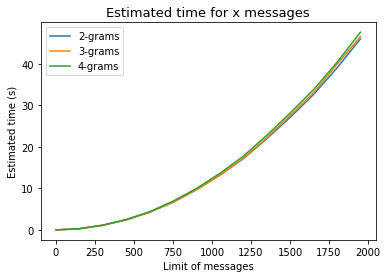

In [32]:
plt.plot(x,y_2,label ='2-grams')
plt.plot(x,y,label ='3-grams')
plt.plot(x,y_4,label ='4-grams')
plt.legend()
plt.xlabel(xlabel='Limit of messages')
plt.ylabel(ylabel='Estimated time (s)')
plt.title("Estimated time for x messages", fontsize = 13.0)
plt.show()

<font size="+1">As we can see in the plot, the efficiency between different ngrams is very similar, we can see that 2-grams is slightly faster than 3 and 4 but it is not a big variation. In terms of effectiveness and accuracy are also very similar with the same duplicate detection percentage. </font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>